In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go

In [2]:
retail_df = pd.read_csv("retail_sales.csv")

# Clean and preprocess based on new columns
retail_df['date'] = pd.to_datetime(retail_df['date'])
retail_df['review'] = retail_df.groupby('item')['review'].transform(lambda x: x.fillna(x.mean()))
retail_df['month'] = retail_df['date'].dt.to_period('M')

# Define the actual clothing items without the extra things
clothing_items = [
    'Tunic', 'Tank Top', 'Leggings', 'Onesie', 'Jacket', 'Trousers', 'Jeans',
    'Pajamas', 'Trench Coat', 'Poncho', 'Romper', 'T-shirt', 'Shorts',
    'Blazer', 'Hoodie', 'Sweater', 'Blouse', 'Swimsuit', 'Kimono', 'Cardigan',
    'Dress', 'Camisole', 'Flannel Shirt', 'Polo Shirt', 'Overalls', 'Coat',
    'Vest', 'Jumpsuit', 'Raincoat', 'Skirt', 'Pants'
]
# Filter df so it only has clothing items
retail_df = retail_df[retail_df['item'].isin(clothing_items)].reset_index(drop=True)
retail_df.head()

,customerID,item,amount_usd,date,review,payment,month
0,4115,Tunic,2456.0,2023-07-11,2.0,Credit Card,2023-07
1,4019,Tank Top,2102.0,2023-03-23,4.1,Cash,2023-03
2,4097,Leggings,3126.0,2023-03-15,3.2,Cash,2023-03
3,4080,Onesie,2914.0,2022-12-11,4.5,Credit Card,2022-12
4,4055,Jacket,2571.0,2023-07-08,1.3,Cash,2023-07


In [3]:
# Create matrix of user reviews
user_item_matrix = retail_df.pivot_table(
    index='customerID',
    columns='item',
    values='review',
    aggfunc='mean'
)

# Fill missing values with 0 
user_item_filled = user_item_matrix.fillna(0)

# Transpose to get item-item matrix
item_user_matrix = user_item_filled.T

# Compute cosine similarity between items
item_similarity_matrix = cosine_similarity(item_user_matrix)
item_similarity_df = pd.DataFrame(item_similarity_matrix, index=item_user_matrix.index, columns=item_user_matrix.index)


item_similarity_df

item,Blazer,Blouse,Camisole,Cardigan,Coat,Dress,Flannel Shirt,Hoodie,Jacket,Jeans,...,Shorts,Skirt,Sweater,Swimsuit,T-shirt,Tank Top,Trench Coat,Trousers,Tunic,Vest
item,,,,,,,,,,,,,,,,,,,,,
Blazer,1.000000,0.348284,0.349055,0.331050,0.360024,0.296403,0.309295,0.319999,0.413664,0.321822,...,0.396543,0.308012,0.306777,0.204395,0.343553,0.383639,0.384337,0.300074,0.323443,0.282703
Blouse,0.348284,1.000000,0.238680,0.402870,0.344008,0.208683,0.222139,0.313108,0.289283,0.241549,...,0.308749,0.218849,0.254768,0.274967,0.363666,0.284071,0.264691,0.337129,0.232938,0.339633
Camisole,0.349055,0.238680,1.000000,0.279480,0.356068,0.235960,0.310948,0.346384,0.289172,0.326837,...,0.238724,0.405355,0.409164,0.356844,0.227193,0.383605,0.277181,0.311930,0.187487,0.334823
Cardigan,0.331050,0.402870,0.279480,1.000000,0.262328,0.337319,0.259273,0.325190,0.453705,0.308793,...,0.344584,0.237715,0.319214,0.323505,0.314964,0.288567,0.411656,0.328496,0.292806,0.271826
Coat,0.360024,0.344008,0.356068,0.262328,1.000000,0.264551,0.251089,0.308847,0.377615,0.293886,...,0.294332,0.306071,0.230326,0.227414,0.286339,0.259628,0.163280,0.239888,0.272163,0.310335
Dress,0.296403,0.208683,0.235960,0.337319,0.264551,1.000000,0.212884,0.314027,0.295138,0.274082,...,0.314526,0.361259,0.295679,0.377742,0.327135,0.367897,0.305986,0.222672,0.322627,0.288862
Flannel Shirt,0.309295,0.222139,0.310948,0.259273,0.251089,0.212884,1.000000,0.227960,0.320544,0.249775,...,0.316524,0.319040,0.406242,0.281695,0.293643,0.266658,0.359449,0.291808,0.387098,0.222796
Hoodie,0.319999,0.313108,0.346384,0.325190,0.308847,0.314027,0.227960,1.000000,0.296034,0.208540,...,0.249011,0.399285,0.308826,0.308067,0.388699,0.372985,0.321582,0.269982,0.264777,0.309320
Jacket,0.413664,0.289283,0.289172,0.453705,0.377615,0.295138,0.320544,0.296034,1.000000,0.309526,...,0.234537,0.200932,0.260196,0.217484,0.263752,0.257613,0.274088,0.281532,0.257259,0.302168


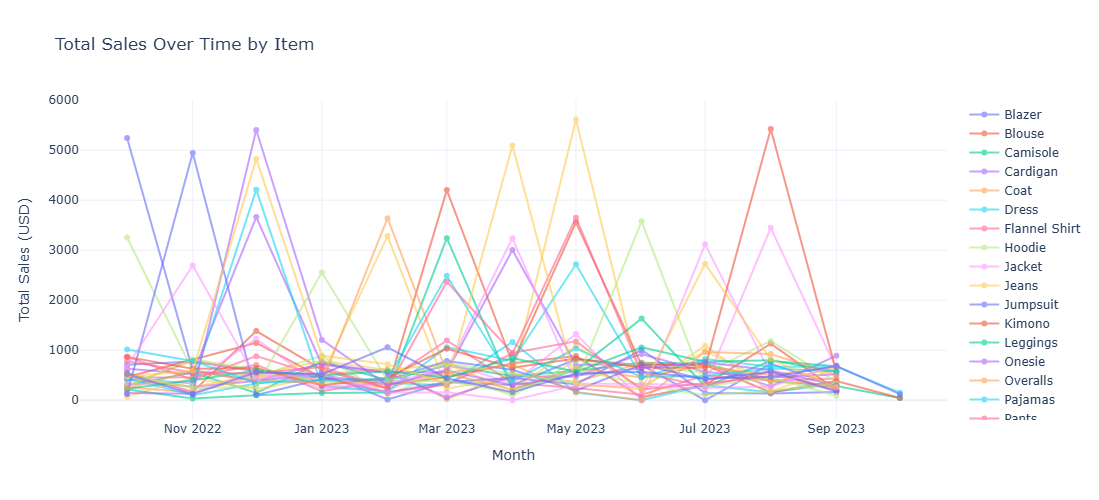

In [13]:
retail_df['month'] = pd.to_datetime(retail_df['date']).dt.to_period("M")
ts_sales = retail_df.groupby(['item', 'month']).agg(
    Total_Sales=('amount_usd', 'sum')
).reset_index()
ts_sales['month'] = ts_sales['month'].dt.to_timestamp()

# Plotly graph Time Series
fig = go.Figure()

for item in ts_sales['item'].unique():
    item_data = ts_sales[ts_sales['item'] == item]
    fig.add_trace(go.Scatter(
        x=item_data['month'],
        y=item_data['Total_Sales'],
        mode='lines+markers',
        name=item,
        hoverinfo='text',
        text=[f"Item: {item}<br>Sales: ${val}" for val in item_data['Total_Sales']],
        line=dict(width=2),
        opacity=0.6
    ))

fig.update_layout(
    title="Total Sales Over Time by Item",
    xaxis_title="Month",
    yaxis_title="Total Sales (USD)",
    hovermode='x unified',
    template='plotly_white',
    height=500
)

fig.show()
